# Pytorch two-layred perceptron

__Task__: construct a perceptron model using `PyTorch` and learn on MNIST dataset for digit recognition problem

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score

from typing import Tuple, List, Type, Dict, Any

Inititalize GPU device

In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

Fix RNG seed to make the experiment reproducable

In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Perceptron class

In [4]:
class Perceptron(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super().__init__()
        self.input_resolution = input_resolution
        self.input_channels = input_channels
        self.hidden_layer_features = hidden_layer_features
        self.activation = activation()
        self.num_classes = num_classes
        
        self.linear1 = torch.nn.Linear(np.prod(input_resolution), hidden_layer_features[0])
        self.linear2 = torch.nn.Linear(hidden_layer_features[0], num_classes)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)  # ReLU used as layer 1 activation function
        x = self.linear2(x)
        output = torch.nn.functional.softmax(x, dim=1)
        
        
        return output

Print the number of model parameters. It should be of order 10<sup>5</sup>.

In [5]:
model = Perceptron()
model.to(device)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (activation): ReLU()
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)
Total number of trainable parameters 203530


Image processing pipeline. Imnput images (presented as NumPy arrays) are converted to PyTorch tensors and normalized

In [6]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0, 1)
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0, 1)
])

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Print random images from the dataset

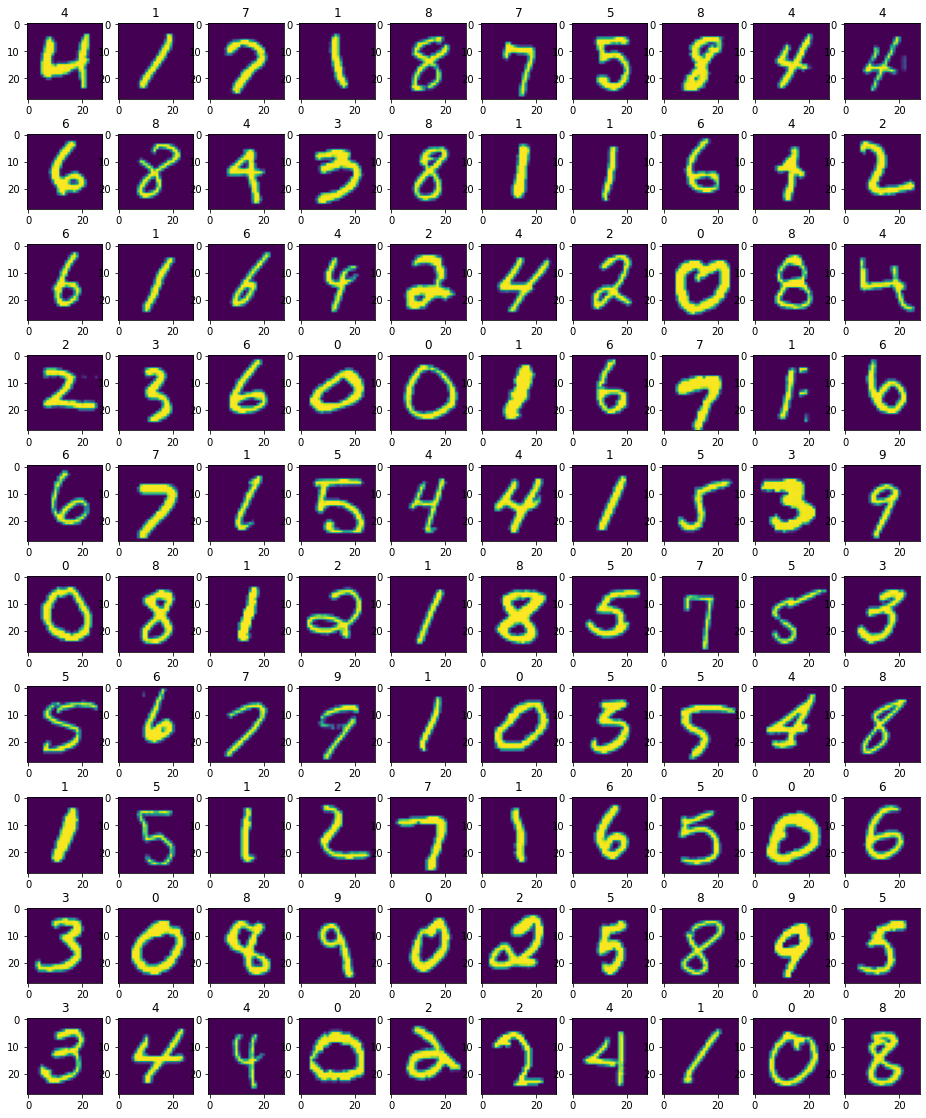

In [8]:
indices = np.random.randint(0, len(train_dataset), size=100)

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(16, 20))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*10+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0).squeeze(axis=2))
        ax.set_title(label)

Training pipeline

In [9]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 20):
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    train_accuracy = []
    val_accuracy = []
    train_loss = []
    val_loss = []

    for epoch in tqdm(range(max_epochs)):
        
        print(f'Epoch {epoch}')
        train_metrics = train_single_epoch(model, optimizer, loss_function, train_loader)
        train_accuracy.append(train_metrics['accuracy'])
        train_loss.append(train_metrics['loss'].item())

        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        val_accuracy.append(val_metrics['accuracy'])
        val_loss.append(val_metrics['loss'].item())
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            break

    return train_accuracy, val_accuracy, train_loss, val_loss

Functions for training and validation in a single eopch 

In [10]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    total_loss = 0
    total_score = 0
    for images, labels in data_loader:
        images = images.view(-1, 784) 
        images, labels = images.to(device), labels.to(device)
        predictions = model.forward(images)
        loss = loss_function(predictions, labels)
        total_loss += loss
        score = accuracy_score(predictions.argmax(dim=1).cpu().numpy(), labels.cpu().numpy())
        total_score += score
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return {'loss': total_loss / len(data_loader),
           'accuracy': total_score / len(data_loader)}

In [11]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    total_loss = 0
    total_score = 0
    for images, labels in data_loader:
        images = images.view(-1, 784)
        images, labels = images.to(device), labels.to(device)
        predictions = model.forward(images)
        loss = loss_function(predictions, labels)
        total_loss += loss
        score = accuracy_score(predictions.argmax(dim=1).cpu().numpy(), labels.cpu().numpy())
        total_score += score
            
    return {'loss': total_loss / len(data_loader),
           'accuracy': total_score / len(data_loader)}

Train the model, trying to achieve more than 90% accuracy

In [12]:
train_accuracy, val_accuracy, train_loss, val_loss = train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0


  0%|          | 1/1000 [00:16<4:26:58, 16.03s/it]

Validation metrics: 
{'loss': tensor(1.5353, grad_fn=<DivBackward0>), 'accuracy': 0.9261544585987261}
Best model yet, saving
Epoch 1


  0%|          | 2/1000 [00:33<4:35:11, 16.54s/it]

Validation metrics: 
{'loss': tensor(1.5270, grad_fn=<DivBackward0>), 'accuracy': 0.9340167197452229}
Best model yet, saving
Epoch 2


  0%|          | 3/1000 [00:51<4:41:14, 16.92s/it]

Validation metrics: 
{'loss': tensor(1.5320, grad_fn=<DivBackward0>), 'accuracy': 0.9287420382165605}
Epoch 3


  0%|          | 4/1000 [01:09<4:43:35, 17.08s/it]

Validation metrics: 
{'loss': tensor(1.5240, grad_fn=<DivBackward0>), 'accuracy': 0.9368033439490446}
Best model yet, saving
Epoch 4


  0%|          | 5/1000 [01:26<4:44:21, 17.15s/it]

Validation metrics: 
{'loss': tensor(1.5242, grad_fn=<DivBackward0>), 'accuracy': 0.9366042993630573}
Epoch 5


  1%|          | 6/1000 [01:43<4:43:52, 17.14s/it]

Validation metrics: 
{'loss': tensor(1.5075, grad_fn=<DivBackward0>), 'accuracy': 0.9539211783439491}
Best model yet, saving
Epoch 6


  1%|          | 7/1000 [02:00<4:42:45, 17.09s/it]

Validation metrics: 
{'loss': tensor(1.5179, grad_fn=<DivBackward0>), 'accuracy': 0.9429737261146497}
Epoch 7


  1%|          | 8/1000 [02:17<4:43:02, 17.12s/it]

Validation metrics: 
{'loss': tensor(1.5125, grad_fn=<DivBackward0>), 'accuracy': 0.948546974522293}
Epoch 8


  1%|          | 9/1000 [02:34<4:42:26, 17.10s/it]

Validation metrics: 
{'loss': tensor(1.5289, grad_fn=<DivBackward0>), 'accuracy': 0.9324243630573248}
Epoch 9


  1%|          | 10/1000 [02:51<4:41:13, 17.04s/it]

Validation metrics: 
{'loss': tensor(1.5155, grad_fn=<DivBackward0>), 'accuracy': 0.9456608280254777}
Epoch 10


  1%|          | 11/1000 [03:08<4:40:48, 17.04s/it]

Validation metrics: 
{'loss': tensor(1.5232, grad_fn=<DivBackward0>), 'accuracy': 0.9375995222929936}
Epoch 11


  1%|          | 12/1000 [03:25<4:39:53, 17.00s/it]

Validation metrics: 
{'loss': tensor(1.5257, grad_fn=<DivBackward0>), 'accuracy': 0.9352109872611465}
Epoch 12


  1%|▏         | 13/1000 [03:42<4:39:08, 16.97s/it]

Validation metrics: 
{'loss': tensor(1.5266, grad_fn=<DivBackward0>), 'accuracy': 0.9345143312101911}
Epoch 13


  1%|▏         | 14/1000 [03:59<4:38:34, 16.95s/it]

Validation metrics: 
{'loss': tensor(1.5172, grad_fn=<DivBackward0>), 'accuracy': 0.9440684713375797}
Epoch 14


  2%|▏         | 15/1000 [04:16<4:37:56, 16.93s/it]

Validation metrics: 
{'loss': tensor(1.5175, grad_fn=<DivBackward0>), 'accuracy': 0.9432722929936306}
Epoch 15


  2%|▏         | 16/1000 [04:33<4:38:14, 16.97s/it]

Validation metrics: 
{'loss': tensor(1.5145, grad_fn=<DivBackward0>), 'accuracy': 0.9465565286624203}
Epoch 16


  2%|▏         | 17/1000 [04:50<4:38:12, 16.98s/it]

Validation metrics: 
{'loss': tensor(1.5052, grad_fn=<DivBackward0>), 'accuracy': 0.9559116242038217}
Best model yet, saving
Epoch 17


  2%|▏         | 18/1000 [05:07<4:38:31, 17.02s/it]

Validation metrics: 
{'loss': tensor(1.5040, grad_fn=<DivBackward0>), 'accuracy': 0.9571058917197452}
Best model yet, saving
Epoch 18


  2%|▏         | 19/1000 [05:24<4:37:18, 16.96s/it]

Validation metrics: 
{'loss': tensor(1.5140, grad_fn=<DivBackward0>), 'accuracy': 0.9472531847133758}
Epoch 19


  2%|▏         | 20/1000 [05:41<4:36:59, 16.96s/it]

Validation metrics: 
{'loss': tensor(1.5154, grad_fn=<DivBackward0>), 'accuracy': 0.9456608280254777}
Epoch 20


  2%|▏         | 21/1000 [05:58<4:36:20, 16.94s/it]

Validation metrics: 
{'loss': tensor(1.5093, grad_fn=<DivBackward0>), 'accuracy': 0.9517316878980892}
Epoch 21


  2%|▏         | 22/1000 [06:14<4:35:50, 16.92s/it]

Validation metrics: 
{'loss': tensor(1.5134, grad_fn=<DivBackward0>), 'accuracy': 0.9477507961783439}
Epoch 22


  2%|▏         | 23/1000 [06:31<4:34:49, 16.88s/it]

Validation metrics: 
{'loss': tensor(1.5172, grad_fn=<DivBackward0>), 'accuracy': 0.943968949044586}
Epoch 23


  2%|▏         | 24/1000 [06:48<4:34:14, 16.86s/it]

Validation metrics: 
{'loss': tensor(1.5187, grad_fn=<DivBackward0>), 'accuracy': 0.9424761146496815}
Epoch 24


  2%|▎         | 25/1000 [07:05<4:34:41, 16.90s/it]

Validation metrics: 
{'loss': tensor(1.5157, grad_fn=<DivBackward0>), 'accuracy': 0.9454617834394905}
Epoch 25


  3%|▎         | 26/1000 [07:22<4:34:29, 16.91s/it]

Validation metrics: 
{'loss': tensor(1.5098, grad_fn=<DivBackward0>), 'accuracy': 0.951234076433121}
Epoch 26


  3%|▎         | 27/1000 [07:39<4:33:51, 16.89s/it]

Validation metrics: 
{'loss': tensor(1.5105, grad_fn=<DivBackward0>), 'accuracy': 0.9507364649681529}
Epoch 27


  3%|▎         | 28/1000 [07:56<4:33:20, 16.87s/it]

Validation metrics: 
{'loss': tensor(1.5072, grad_fn=<DivBackward0>), 'accuracy': 0.9538216560509554}
Epoch 28


  3%|▎         | 29/1000 [08:13<4:33:29, 16.90s/it]

Validation metrics: 
{'loss': tensor(1.5109, grad_fn=<DivBackward0>), 'accuracy': 0.9503383757961783}
Epoch 29


  3%|▎         | 30/1000 [08:29<4:32:47, 16.87s/it]

Validation metrics: 
{'loss': tensor(1.5043, grad_fn=<DivBackward0>), 'accuracy': 0.9568073248407644}
Epoch 30


  3%|▎         | 31/1000 [08:46<4:32:41, 16.88s/it]

Validation metrics: 
{'loss': tensor(1.5004, grad_fn=<DivBackward0>), 'accuracy': 0.9606886942675159}
Best model yet, saving
Epoch 31


  3%|▎         | 32/1000 [09:03<4:32:47, 16.91s/it]

Validation metrics: 
{'loss': tensor(1.4993, grad_fn=<DivBackward0>), 'accuracy': 0.9617834394904459}
Best model yet, saving
Epoch 32


  3%|▎         | 33/1000 [09:20<4:33:05, 16.94s/it]

Validation metrics: 
{'loss': tensor(1.4984, grad_fn=<DivBackward0>), 'accuracy': 0.9627786624203821}
Best model yet, saving
Epoch 33


  3%|▎         | 34/1000 [09:37<4:32:41, 16.94s/it]

Validation metrics: 
{'loss': tensor(1.4974, grad_fn=<DivBackward0>), 'accuracy': 0.9636743630573248}
Best model yet, saving
Epoch 34


  4%|▎         | 35/1000 [09:54<4:32:43, 16.96s/it]

Validation metrics: 
{'loss': tensor(1.4970, grad_fn=<DivBackward0>), 'accuracy': 0.964171974522293}
Best model yet, saving
Epoch 35


  4%|▎         | 36/1000 [10:12<4:35:12, 17.13s/it]

Validation metrics: 
{'loss': tensor(1.4971, grad_fn=<DivBackward0>), 'accuracy': 0.9639729299363057}
Epoch 36


  4%|▎         | 37/1000 [10:29<4:34:36, 17.11s/it]

Validation metrics: 
{'loss': tensor(1.4956, grad_fn=<DivBackward0>), 'accuracy': 0.9654657643312102}
Best model yet, saving
Epoch 37


  4%|▍         | 38/1000 [10:46<4:34:56, 17.15s/it]

Validation metrics: 
{'loss': tensor(1.4941, grad_fn=<DivBackward0>), 'accuracy': 0.9670581210191083}
Best model yet, saving
Epoch 38


  4%|▍         | 39/1000 [11:03<4:35:48, 17.22s/it]

Validation metrics: 
{'loss': tensor(1.4943, grad_fn=<DivBackward0>), 'accuracy': 0.9667595541401274}
Epoch 39


  4%|▍         | 40/1000 [11:21<4:36:56, 17.31s/it]

Validation metrics: 
{'loss': tensor(1.4933, grad_fn=<DivBackward0>), 'accuracy': 0.9678542993630573}
Best model yet, saving
Epoch 40


  4%|▍         | 41/1000 [11:38<4:36:48, 17.32s/it]

Validation metrics: 
{'loss': tensor(1.4948, grad_fn=<DivBackward0>), 'accuracy': 0.9663614649681529}
Epoch 41


  4%|▍         | 42/1000 [11:56<4:40:05, 17.54s/it]

Validation metrics: 
{'loss': tensor(1.4933, grad_fn=<DivBackward0>), 'accuracy': 0.9678542993630573}
Epoch 42


  4%|▍         | 43/1000 [12:14<4:41:32, 17.65s/it]

Validation metrics: 
{'loss': tensor(1.4933, grad_fn=<DivBackward0>), 'accuracy': 0.96765525477707}
Epoch 43


  4%|▍         | 44/1000 [12:32<4:43:09, 17.77s/it]

Validation metrics: 
{'loss': tensor(1.4934, grad_fn=<DivBackward0>), 'accuracy': 0.9677547770700637}
Epoch 44


  4%|▍         | 45/1000 [12:50<4:44:42, 17.89s/it]

Validation metrics: 
{'loss': tensor(1.4920, grad_fn=<DivBackward0>), 'accuracy': 0.9690485668789809}
Best model yet, saving
Epoch 45


  5%|▍         | 46/1000 [13:08<4:44:11, 17.87s/it]

Validation metrics: 
{'loss': tensor(1.4924, grad_fn=<DivBackward0>), 'accuracy': 0.96875}
Epoch 46


  5%|▍         | 47/1000 [13:27<4:45:47, 17.99s/it]

Validation metrics: 
{'loss': tensor(1.4919, grad_fn=<DivBackward0>), 'accuracy': 0.9691480891719745}
Best model yet, saving
Epoch 47


  5%|▍         | 48/1000 [13:45<4:45:24, 17.99s/it]

Validation metrics: 
{'loss': tensor(1.4915, grad_fn=<DivBackward0>), 'accuracy': 0.9695461783439491}
Best model yet, saving
Epoch 48


  5%|▍         | 49/1000 [14:03<4:46:03, 18.05s/it]

Validation metrics: 
{'loss': tensor(1.4920, grad_fn=<DivBackward0>), 'accuracy': 0.9690485668789809}
Epoch 49


  5%|▌         | 50/1000 [14:21<4:47:50, 18.18s/it]

Validation metrics: 
{'loss': tensor(1.4920, grad_fn=<DivBackward0>), 'accuracy': 0.9691480891719745}
Epoch 50


  5%|▌         | 51/1000 [14:40<4:49:09, 18.28s/it]

Validation metrics: 
{'loss': tensor(1.4919, grad_fn=<DivBackward0>), 'accuracy': 0.9692476114649682}
Epoch 51


  5%|▌         | 52/1000 [14:59<4:51:17, 18.44s/it]

Validation metrics: 
{'loss': tensor(1.4924, grad_fn=<DivBackward0>), 'accuracy': 0.9685509554140127}
Epoch 52


  5%|▌         | 53/1000 [15:17<4:52:12, 18.51s/it]

Validation metrics: 
{'loss': tensor(1.4928, grad_fn=<DivBackward0>), 'accuracy': 0.9681528662420382}
Epoch 53


  5%|▌         | 54/1000 [15:36<4:50:43, 18.44s/it]

Validation metrics: 
{'loss': tensor(1.4916, grad_fn=<DivBackward0>), 'accuracy': 0.9695461783439491}
Epoch 54


  6%|▌         | 55/1000 [15:54<4:49:16, 18.37s/it]

Validation metrics: 
{'loss': tensor(1.4912, grad_fn=<DivBackward0>), 'accuracy': 0.9699442675159236}
Best model yet, saving
Epoch 55


  6%|▌         | 56/1000 [16:12<4:48:23, 18.33s/it]

Validation metrics: 
{'loss': tensor(1.4938, grad_fn=<DivBackward0>), 'accuracy': 0.9674562101910829}
Epoch 56


  6%|▌         | 57/1000 [16:30<4:47:41, 18.31s/it]

Validation metrics: 
{'loss': tensor(1.4921, grad_fn=<DivBackward0>), 'accuracy': 0.9689490445859873}
Epoch 57


  6%|▌         | 58/1000 [16:49<4:47:43, 18.33s/it]

Validation metrics: 
{'loss': tensor(1.4913, grad_fn=<DivBackward0>), 'accuracy': 0.9699442675159236}
Epoch 58


  6%|▌         | 59/1000 [17:07<4:47:37, 18.34s/it]

Validation metrics: 
{'loss': tensor(1.4906, grad_fn=<DivBackward0>), 'accuracy': 0.970640923566879}
Best model yet, saving
Epoch 59


  6%|▌         | 60/1000 [17:26<4:49:11, 18.46s/it]

Validation metrics: 
{'loss': tensor(1.4901, grad_fn=<DivBackward0>), 'accuracy': 0.9710390127388535}
Best model yet, saving
Epoch 60


  6%|▌         | 61/1000 [17:44<4:50:12, 18.54s/it]

Validation metrics: 
{'loss': tensor(1.4907, grad_fn=<DivBackward0>), 'accuracy': 0.9703423566878981}
Epoch 61


  6%|▌         | 62/1000 [18:03<4:51:02, 18.62s/it]

Validation metrics: 
{'loss': tensor(1.4904, grad_fn=<DivBackward0>), 'accuracy': 0.970640923566879}
Epoch 62


  6%|▋         | 63/1000 [18:22<4:51:45, 18.68s/it]

Validation metrics: 
{'loss': tensor(1.4912, grad_fn=<DivBackward0>), 'accuracy': 0.9699442675159236}
Epoch 63


  6%|▋         | 64/1000 [18:41<4:51:19, 18.67s/it]

Validation metrics: 
{'loss': tensor(1.4903, grad_fn=<DivBackward0>), 'accuracy': 0.9708399681528662}
Epoch 64


  6%|▋         | 65/1000 [19:00<4:52:07, 18.75s/it]

Validation metrics: 
{'loss': tensor(1.4906, grad_fn=<DivBackward0>), 'accuracy': 0.9705414012738853}
Epoch 65


  7%|▋         | 66/1000 [19:19<4:52:33, 18.79s/it]

Validation metrics: 
{'loss': tensor(1.4900, grad_fn=<DivBackward0>), 'accuracy': 0.9711385350318471}
Best model yet, saving
Epoch 66


  7%|▋         | 67/1000 [19:38<4:53:50, 18.90s/it]

Validation metrics: 
{'loss': tensor(1.4906, grad_fn=<DivBackward0>), 'accuracy': 0.9705414012738853}
Epoch 67


  7%|▋         | 68/1000 [19:57<4:54:51, 18.98s/it]

Validation metrics: 
{'loss': tensor(1.4902, grad_fn=<DivBackward0>), 'accuracy': 0.9711385350318471}
Epoch 68


  7%|▋         | 69/1000 [20:16<4:56:23, 19.10s/it]

Validation metrics: 
{'loss': tensor(1.4896, grad_fn=<DivBackward0>), 'accuracy': 0.9716361464968153}
Best model yet, saving
Epoch 69


  7%|▋         | 70/1000 [20:36<5:00:16, 19.37s/it]

Validation metrics: 
{'loss': tensor(1.4895, grad_fn=<DivBackward0>), 'accuracy': 0.9716361464968153}
Best model yet, saving
Epoch 70


  7%|▋         | 71/1000 [20:56<5:01:30, 19.47s/it]

Validation metrics: 
{'loss': tensor(1.4893, grad_fn=<DivBackward0>), 'accuracy': 0.9718351910828026}
Best model yet, saving
Epoch 71


  7%|▋         | 72/1000 [21:16<5:02:13, 19.54s/it]

Validation metrics: 
{'loss': tensor(1.4899, grad_fn=<DivBackward0>), 'accuracy': 0.9712380573248408}
Epoch 72


  7%|▋         | 73/1000 [21:35<5:03:19, 19.63s/it]

Validation metrics: 
{'loss': tensor(1.4895, grad_fn=<DivBackward0>), 'accuracy': 0.9717356687898089}
Epoch 73


  7%|▋         | 74/1000 [21:55<5:03:55, 19.69s/it]

Validation metrics: 
{'loss': tensor(1.4895, grad_fn=<DivBackward0>), 'accuracy': 0.9715366242038217}
Epoch 74


  8%|▊         | 75/1000 [22:15<5:04:36, 19.76s/it]

Validation metrics: 
{'loss': tensor(1.4894, grad_fn=<DivBackward0>), 'accuracy': 0.9718351910828026}
Epoch 75


  8%|▊         | 76/1000 [22:38<5:18:58, 20.71s/it]

Validation metrics: 
{'loss': tensor(1.4884, grad_fn=<DivBackward0>), 'accuracy': 0.9726313694267515}
Best model yet, saving
Epoch 76


  8%|▊         | 77/1000 [22:58<5:15:05, 20.48s/it]

Validation metrics: 
{'loss': tensor(1.4883, grad_fn=<DivBackward0>), 'accuracy': 0.9728304140127388}
Best model yet, saving
Epoch 77


  8%|▊         | 78/1000 [23:18<5:12:50, 20.36s/it]

Validation metrics: 
{'loss': tensor(1.4890, grad_fn=<DivBackward0>), 'accuracy': 0.9722332802547771}
Epoch 78


  8%|▊         | 79/1000 [23:38<5:11:47, 20.31s/it]

Validation metrics: 
{'loss': tensor(1.4892, grad_fn=<DivBackward0>), 'accuracy': 0.9720342356687898}
Epoch 79


  8%|▊         | 80/1000 [23:59<5:10:33, 20.25s/it]

Validation metrics: 
{'loss': tensor(1.4893, grad_fn=<DivBackward0>), 'accuracy': 0.9718351910828026}
Epoch 80


  8%|▊         | 81/1000 [24:19<5:10:46, 20.29s/it]

Validation metrics: 
{'loss': tensor(1.4893, grad_fn=<DivBackward0>), 'accuracy': 0.9718351910828026}
Epoch 81


  8%|▊         | 82/1000 [24:39<5:10:57, 20.32s/it]

Validation metrics: 
{'loss': tensor(1.4888, grad_fn=<DivBackward0>), 'accuracy': 0.9723328025477707}
Epoch 82


  8%|▊         | 83/1000 [25:00<5:10:37, 20.32s/it]

Validation metrics: 
{'loss': tensor(1.4891, grad_fn=<DivBackward0>), 'accuracy': 0.9720342356687898}
Epoch 83


  8%|▊         | 84/1000 [25:20<5:10:46, 20.36s/it]

Validation metrics: 
{'loss': tensor(1.4887, grad_fn=<DivBackward0>), 'accuracy': 0.9724323248407644}
Epoch 84


  8%|▊         | 85/1000 [25:41<5:14:05, 20.60s/it]

Validation metrics: 
{'loss': tensor(1.4886, grad_fn=<DivBackward0>), 'accuracy': 0.9724323248407644}
Epoch 85


  9%|▊         | 86/1000 [26:02<5:14:22, 20.64s/it]

Validation metrics: 
{'loss': tensor(1.4883, grad_fn=<DivBackward0>), 'accuracy': 0.9729299363057324}
Epoch 86


  9%|▊         | 87/1000 [26:23<5:14:52, 20.69s/it]

Validation metrics: 
{'loss': tensor(1.4880, grad_fn=<DivBackward0>), 'accuracy': 0.9731289808917197}
Best model yet, saving
Epoch 87


  9%|▉         | 88/1000 [26:44<5:15:17, 20.74s/it]

Validation metrics: 
{'loss': tensor(1.4874, grad_fn=<DivBackward0>), 'accuracy': 0.9737261146496815}
Best model yet, saving
Epoch 88


  9%|▉         | 89/1000 [27:04<5:15:11, 20.76s/it]

Validation metrics: 
{'loss': tensor(1.4881, grad_fn=<DivBackward0>), 'accuracy': 0.9730294585987261}
Epoch 89


  9%|▉         | 90/1000 [27:25<5:15:24, 20.80s/it]

Validation metrics: 
{'loss': tensor(1.4879, grad_fn=<DivBackward0>), 'accuracy': 0.9732285031847133}
Epoch 90


  9%|▉         | 91/1000 [27:46<5:16:15, 20.88s/it]

Validation metrics: 
{'loss': tensor(1.4884, grad_fn=<DivBackward0>), 'accuracy': 0.9727308917197452}
Epoch 91


  9%|▉         | 92/1000 [28:07<5:16:11, 20.89s/it]

Validation metrics: 
{'loss': tensor(1.4880, grad_fn=<DivBackward0>), 'accuracy': 0.9731289808917197}
Epoch 92


  9%|▉         | 93/1000 [28:28<5:16:00, 20.90s/it]

Validation metrics: 
{'loss': tensor(1.4872, grad_fn=<DivBackward0>), 'accuracy': 0.9739251592356688}
Best model yet, saving
Epoch 93


  9%|▉         | 94/1000 [28:49<5:15:46, 20.91s/it]

Validation metrics: 
{'loss': tensor(1.4876, grad_fn=<DivBackward0>), 'accuracy': 0.9735270700636943}
Epoch 94


 10%|▉         | 95/1000 [29:10<5:14:07, 20.83s/it]

Validation metrics: 
{'loss': tensor(1.4875, grad_fn=<DivBackward0>), 'accuracy': 0.9736265923566879}
Epoch 95


 10%|▉         | 96/1000 [29:30<5:13:03, 20.78s/it]

Validation metrics: 
{'loss': tensor(1.4879, grad_fn=<DivBackward0>), 'accuracy': 0.9732285031847133}
Epoch 96


 10%|▉         | 97/1000 [29:51<5:12:09, 20.74s/it]

Validation metrics: 
{'loss': tensor(1.4873, grad_fn=<DivBackward0>), 'accuracy': 0.9739251592356688}
Epoch 97


 10%|▉         | 98/1000 [30:12<5:12:15, 20.77s/it]

Validation metrics: 
{'loss': tensor(1.4876, grad_fn=<DivBackward0>), 'accuracy': 0.9735270700636943}
Epoch 98


 10%|▉         | 99/1000 [30:33<5:14:14, 20.93s/it]

Validation metrics: 
{'loss': tensor(1.4876, grad_fn=<DivBackward0>), 'accuracy': 0.9735270700636943}
Epoch 99


 10%|█         | 100/1000 [30:55<5:18:38, 21.24s/it]

Validation metrics: 
{'loss': tensor(1.4874, grad_fn=<DivBackward0>), 'accuracy': 0.9737261146496815}
Epoch 100


 10%|█         | 101/1000 [31:17<5:20:10, 21.37s/it]

Validation metrics: 
{'loss': tensor(1.4871, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Best model yet, saving
Epoch 101


 10%|█         | 102/1000 [31:38<5:19:11, 21.33s/it]

Validation metrics: 
{'loss': tensor(1.4868, grad_fn=<DivBackward0>), 'accuracy': 0.9743232484076433}
Best model yet, saving
Epoch 102


 10%|█         | 103/1000 [31:59<5:18:28, 21.30s/it]

Validation metrics: 
{'loss': tensor(1.4874, grad_fn=<DivBackward0>), 'accuracy': 0.9736265923566879}
Epoch 103


 10%|█         | 104/1000 [32:20<5:16:34, 21.20s/it]

Validation metrics: 
{'loss': tensor(1.4880, grad_fn=<DivBackward0>), 'accuracy': 0.9731289808917197}
Epoch 104


 10%|█         | 105/1000 [32:41<5:15:43, 21.17s/it]

Validation metrics: 
{'loss': tensor(1.4881, grad_fn=<DivBackward0>), 'accuracy': 0.9731289808917197}
Epoch 105


 11%|█         | 106/1000 [33:03<5:15:11, 21.15s/it]

Validation metrics: 
{'loss': tensor(1.4869, grad_fn=<DivBackward0>), 'accuracy': 0.9743232484076433}
Epoch 106


 11%|█         | 107/1000 [33:23<5:13:24, 21.06s/it]

Validation metrics: 
{'loss': tensor(1.4882, grad_fn=<DivBackward0>), 'accuracy': 0.9729299363057324}
Epoch 107


 11%|█         | 108/1000 [33:44<5:11:59, 20.99s/it]

Validation metrics: 
{'loss': tensor(1.4878, grad_fn=<DivBackward0>), 'accuracy': 0.9734275477707006}
Epoch 108


 11%|█         | 109/1000 [34:05<5:11:08, 20.95s/it]

Validation metrics: 
{'loss': tensor(1.4876, grad_fn=<DivBackward0>), 'accuracy': 0.9735270700636943}
Epoch 109


 11%|█         | 110/1000 [34:26<5:10:08, 20.91s/it]

Validation metrics: 
{'loss': tensor(1.4876, grad_fn=<DivBackward0>), 'accuracy': 0.9735270700636943}
Epoch 110


 11%|█         | 111/1000 [34:47<5:10:32, 20.96s/it]

Validation metrics: 
{'loss': tensor(1.4879, grad_fn=<DivBackward0>), 'accuracy': 0.973328025477707}
Epoch 111


 11%|█         | 112/1000 [35:08<5:10:00, 20.95s/it]

Validation metrics: 
{'loss': tensor(1.4875, grad_fn=<DivBackward0>), 'accuracy': 0.9735270700636943}
Epoch 112


 11%|█▏        | 113/1000 [35:29<5:09:50, 20.96s/it]

Validation metrics: 
{'loss': tensor(1.4868, grad_fn=<DivBackward0>), 'accuracy': 0.9742237261146497}
Epoch 113


 11%|█▏        | 114/1000 [35:50<5:09:53, 20.99s/it]

Validation metrics: 
{'loss': tensor(1.4869, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Epoch 114


 12%|█▏        | 115/1000 [36:11<5:11:36, 21.13s/it]

Validation metrics: 
{'loss': tensor(1.4868, grad_fn=<DivBackward0>), 'accuracy': 0.9743232484076433}
Epoch 115


 12%|█▏        | 116/1000 [36:32<5:10:44, 21.09s/it]

Validation metrics: 
{'loss': tensor(1.4868, grad_fn=<DivBackward0>), 'accuracy': 0.9743232484076433}
Best model yet, saving
Epoch 116


 12%|█▏        | 117/1000 [36:53<5:10:15, 21.08s/it]

Validation metrics: 
{'loss': tensor(1.4868, grad_fn=<DivBackward0>), 'accuracy': 0.974422770700637}
Best model yet, saving
Epoch 117


 12%|█▏        | 118/1000 [37:14<5:09:25, 21.05s/it]

Validation metrics: 
{'loss': tensor(1.4867, grad_fn=<DivBackward0>), 'accuracy': 0.9745222929936306}
Best model yet, saving
Epoch 118


 12%|█▏        | 119/1000 [37:35<5:09:10, 21.06s/it]

Validation metrics: 
{'loss': tensor(1.4867, grad_fn=<DivBackward0>), 'accuracy': 0.974422770700637}
Best model yet, saving
Epoch 119


 12%|█▏        | 120/1000 [37:57<5:09:35, 21.11s/it]

Validation metrics: 
{'loss': tensor(1.4868, grad_fn=<DivBackward0>), 'accuracy': 0.9743232484076433}
Epoch 120


 12%|█▏        | 121/1000 [38:18<5:09:02, 21.10s/it]

Validation metrics: 
{'loss': tensor(1.4868, grad_fn=<DivBackward0>), 'accuracy': 0.9743232484076433}
Epoch 121


 12%|█▏        | 122/1000 [38:39<5:08:13, 21.06s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Epoch 122


 12%|█▏        | 123/1000 [39:00<5:07:52, 21.06s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Epoch 123


 12%|█▏        | 124/1000 [39:21<5:07:21, 21.05s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 124


 12%|█▎        | 125/1000 [39:42<5:06:31, 21.02s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 125


 13%|█▎        | 126/1000 [40:03<5:05:57, 21.00s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Epoch 126


 13%|█▎        | 127/1000 [40:24<5:05:49, 21.02s/it]

Validation metrics: 
{'loss': tensor(1.4871, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 127


 13%|█▎        | 128/1000 [40:45<5:04:57, 20.98s/it]

Validation metrics: 
{'loss': tensor(1.4871, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 128


 13%|█▎        | 129/1000 [41:06<5:05:07, 21.02s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 129


 13%|█▎        | 130/1000 [41:28<5:07:49, 21.23s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 130


 13%|█▎        | 131/1000 [41:49<5:07:26, 21.23s/it]

Validation metrics: 
{'loss': tensor(1.4871, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 131


 13%|█▎        | 132/1000 [42:10<5:06:56, 21.22s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 132


 13%|█▎        | 133/1000 [42:31<5:06:35, 21.22s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 133


 13%|█▎        | 134/1000 [42:53<5:07:41, 21.32s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9740246815286624}
Epoch 134


 14%|█▎        | 135/1000 [43:15<5:09:28, 21.47s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Epoch 135


 14%|█▎        | 136/1000 [43:36<5:10:27, 21.56s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Epoch 136


 14%|█▎        | 137/1000 [43:58<5:11:25, 21.65s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Epoch 137


 14%|█▍        | 138/1000 [44:20<5:11:01, 21.65s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Epoch 138


 14%|█▍        | 139/1000 [44:41<5:10:03, 21.61s/it]

Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Epoch 139
Validation metrics: 
{'loss': tensor(1.4870, grad_fn=<DivBackward0>), 'accuracy': 0.9741242038216561}
Early stopping triggered


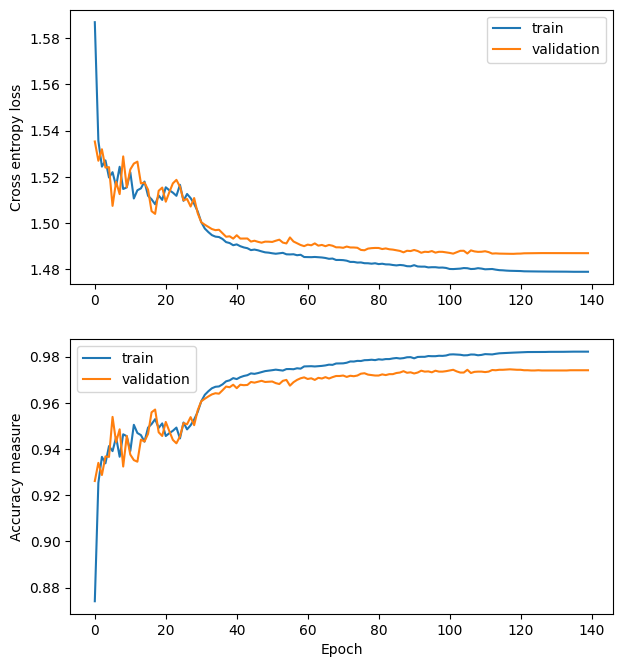

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(7,8), dpi=100)

ax[0].plot(train_loss, label='train')
ax[0].plot(val_loss, label='validation')
ax[0].set_ylabel("Cross entropy loss")
# ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(train_accuracy, label='train')
ax[1].plot(val_accuracy, label='validation')
ax[1].set_ylabel("Accuracy measure")
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.show()